In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_absolute_error, mean_squared_error

/home/muttaqien-m/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.style.use('ggplot')

## Load Data

In [3]:
data_path = "./per_station.xlsx"
data = pd.read_excel(data_path)

# Extract the 'sc2' column data
sc_data = data['sc2'].values

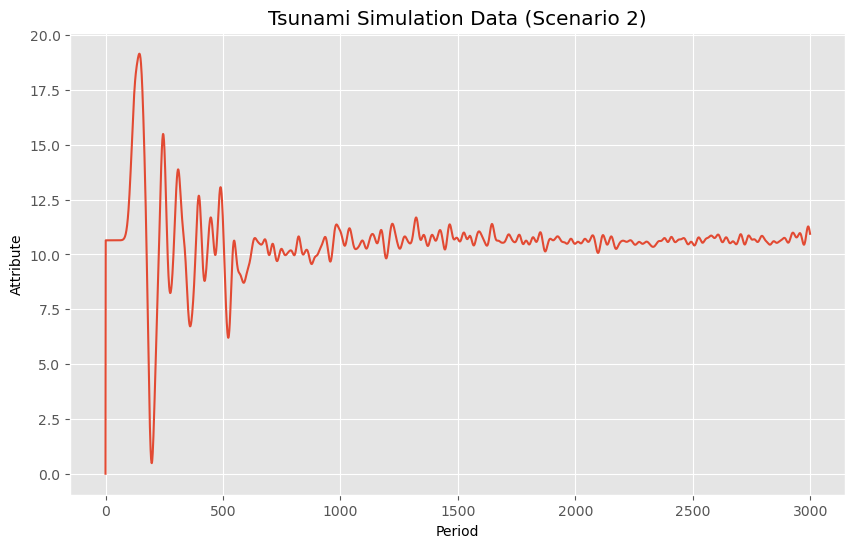

In [4]:
# Generate dummy sales data
series_data = sc_data[:3000]

# Plot the dummy sales data
plt.figure(figsize=(10, 6))
plt.plot(series_data, linestyle='-')
plt.title('Tsunami Simulation Data (Scenario 2)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.grid(True)
plt.show()

## Prepare Data

In [5]:
def prepare_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Prepare the data
X, y = prepare_data(series_data, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.Tensor(X).unsqueeze(-1)  # Add an extra dimension for the input channel
y_tensor = torch.Tensor(y).unsqueeze(-1)

## LSTM Experiment

#### Build Model

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


#### Train Model

In [7]:
# Define training parameters
num_epochs = 200
learning_rate = 0.001
batch_size = 32
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Store losses
losses = []

# Training loop
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    # Shuffle the data and split into batches
    indices = torch.randperm(len(X_tensor))
    X_shuffled = X_tensor[indices]
    y_shuffled = y_tensor[indices]
    
    for i in range(0, len(X_tensor), batch_size):
        
        # Forward pass
        outputs = model(X_shuffled[i:i+batch_size])
        loss = criterion(outputs, y_shuffled[i:i+batch_size])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for the epoch
        epoch_loss += loss.item()
    
    # Average epoch loss
    epoch_loss /= (len(X_tensor) / batch_size)
    losses.append(epoch_loss)
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {epoch_loss:.6f}')

Epoch [1/200], MSE Loss: 32.018589
Epoch [2/200], MSE Loss: 3.001832
Epoch [3/200], MSE Loss: 2.467579
Epoch [4/200], MSE Loss: 2.458805
Epoch [5/200], MSE Loss: 2.363963
Epoch [6/200], MSE Loss: 1.274246
Epoch [7/200], MSE Loss: 0.718675
Epoch [8/200], MSE Loss: 0.521050
Epoch [9/200], MSE Loss: 0.390916
Epoch [10/200], MSE Loss: 0.300217
Epoch [11/200], MSE Loss: 0.259483
Epoch [12/200], MSE Loss: 0.178445
Epoch [13/200], MSE Loss: 0.140498
Epoch [14/200], MSE Loss: 0.110782
Epoch [15/200], MSE Loss: 0.091268
Epoch [16/200], MSE Loss: 0.069844
Epoch [17/200], MSE Loss: 0.054907
Epoch [18/200], MSE Loss: 0.043957
Epoch [19/200], MSE Loss: 0.033741
Epoch [20/200], MSE Loss: 0.026908
Epoch [21/200], MSE Loss: 0.022162
Epoch [22/200], MSE Loss: 0.017585
Epoch [23/200], MSE Loss: 0.012756
Epoch [24/200], MSE Loss: 0.010297
Epoch [25/200], MSE Loss: 0.008733
Epoch [26/200], MSE Loss: 0.006584
Epoch [27/200], MSE Loss: 0.006846
Epoch [28/200], MSE Loss: 0.004896
Epoch [29/200], MSE Loss: 0.

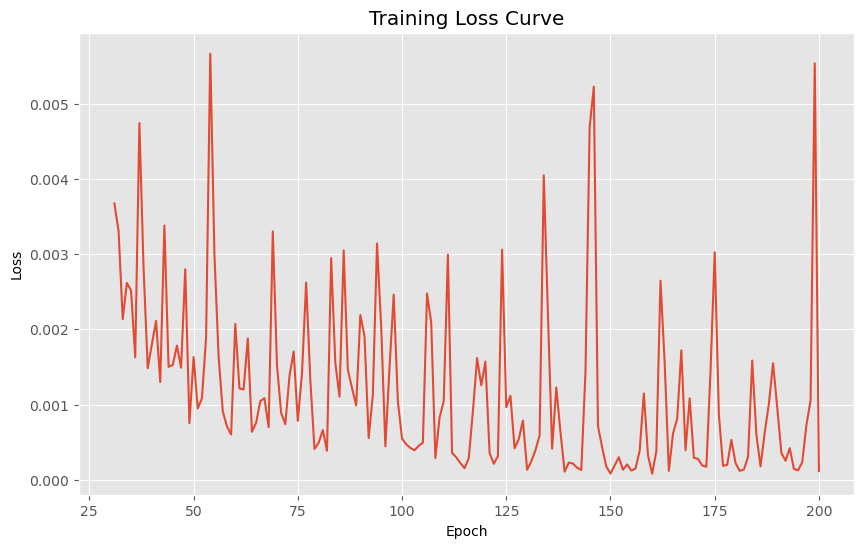

In [8]:
# Plot learning curve
offset = 30

plt.figure(figsize=(10, 6))
plt.plot(range(offset+1, num_epochs+1), losses[offset:], linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#### Evaluate Model

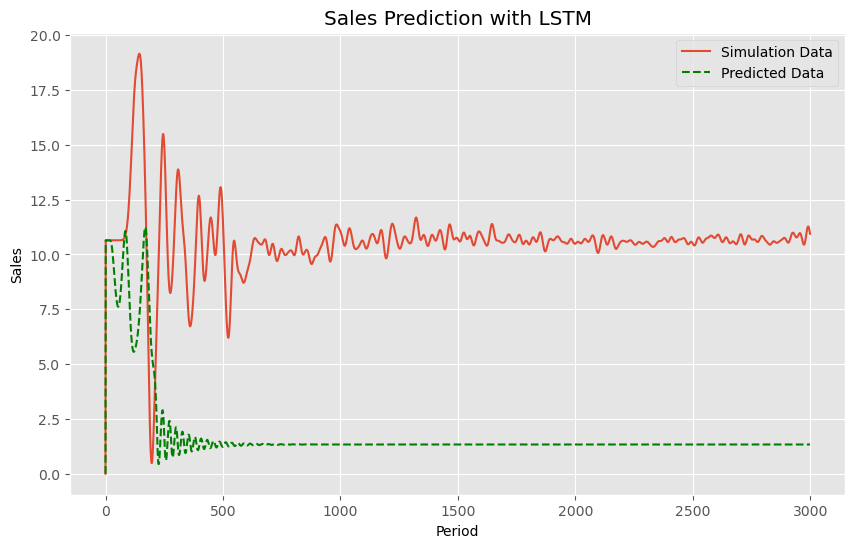

In [10]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)

# Plot the original and predicted sales data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Sales Prediction with LSTM')
plt.xlabel('Period')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 82.40707112122573
Mean Absolute Error (MAE): 8.90500940877426


---